In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import scipy.misc as sm
from scipy import ndimage
from scipy.ndimage.filters import convolve
from scipy import misc
import imageio

In [3]:
def gaussian_kernel(size, sigma=1):
        size = int(size) // 2
        x, y = np.mgrid[-size:size+1, -size:size+1]
        normal = 1 / (2.0 * np.pi * sigma**2)
        g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
        return g

In [4]:
def sobel_filters(img):
        Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
        Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

        Ix = ndimage.filters.convolve(img, Kx)
        Iy = ndimage.filters.convolve(img, Ky)

        G = np.hypot(Ix, Iy)
        G = G / G.max() * 255
        theta = np.arctan2(Iy, Ix)
        return (G, theta)

In [5]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [28]:
def threshold(img):
    
    highThreshold = img.max() * 0.15;
    lowThreshold = highThreshold * 0.09;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [7]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

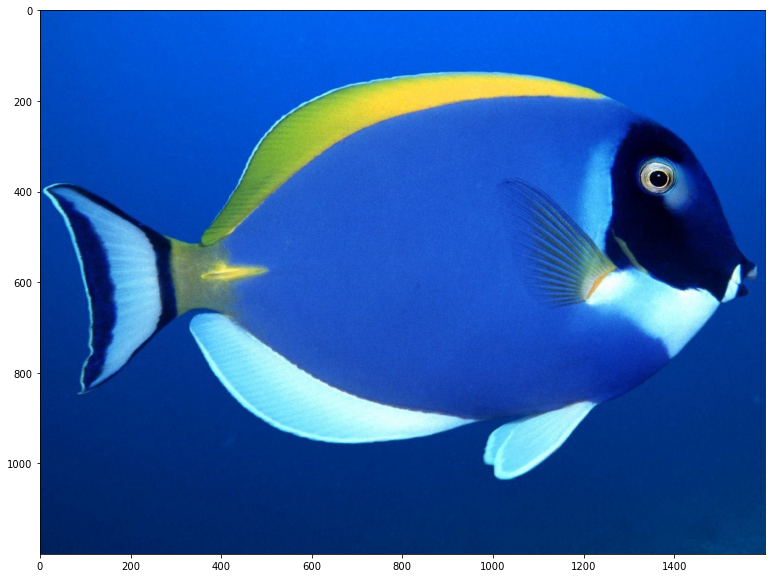

In [20]:
img = imageio.imread("2_fish.jpg")
img = img.astype('int32')
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

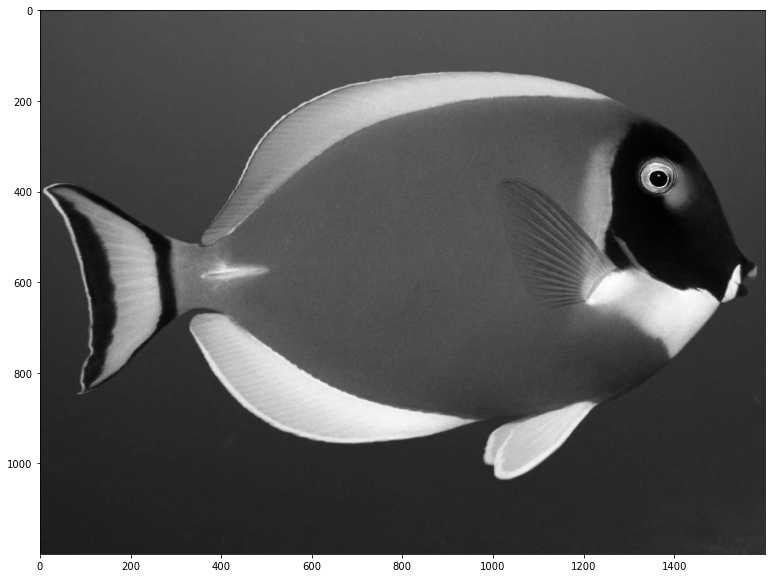

In [21]:
img_gray = np.dot(img[...,:3], [0.299, 0.587, 0.114])
plt.imshow(img_gray, cmap = plt.get_cmap('gray'))
plt.show()

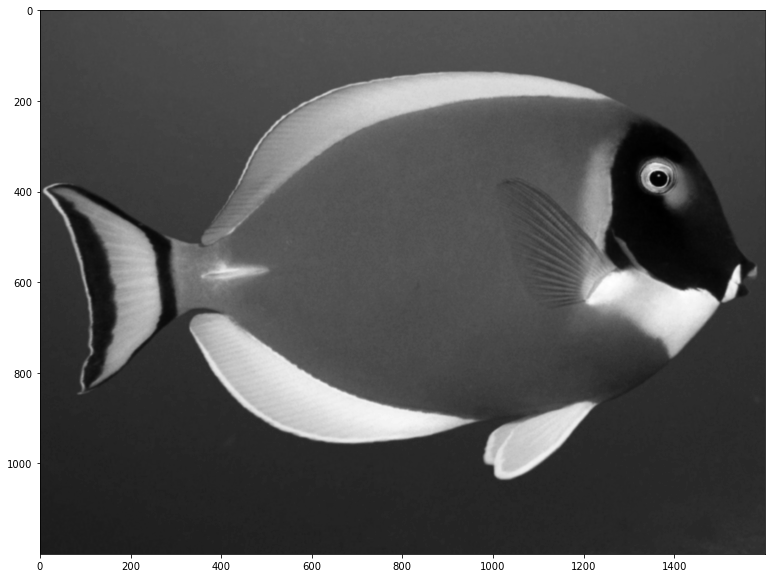

In [22]:
img_guassian_filter=convolve(img_gray,gaussian_kernel(size=5, sigma=1.4))
plt.imshow(img_guassian_filter, cmap = plt.get_cmap('gray'))
plt.show()

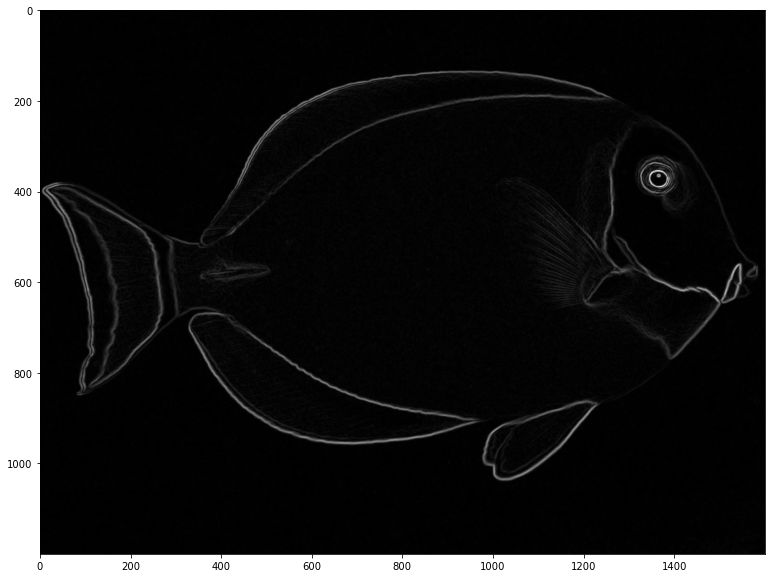

In [23]:
Mag2,Gradient2 =sobel_filters(img_guassian_filter)
Mag2.shape
plt.imshow(Mag2, cmap = plt.get_cmap('gray'))
plt.show()

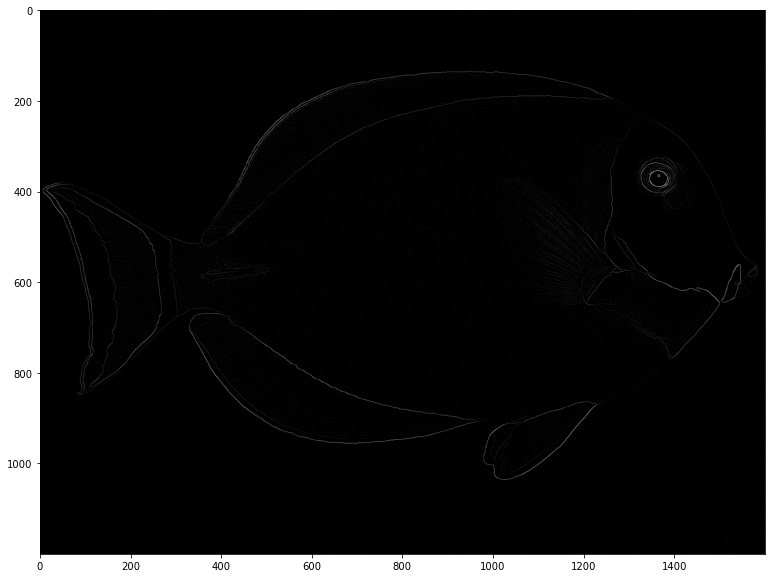

In [24]:
WINMS =non_max_suppression(Mag2,Gradient2)
#WINMS = Normalize(WINMS)
plt.imshow(WINMS, cmap = plt.get_cmap('gray'))
plt.show()

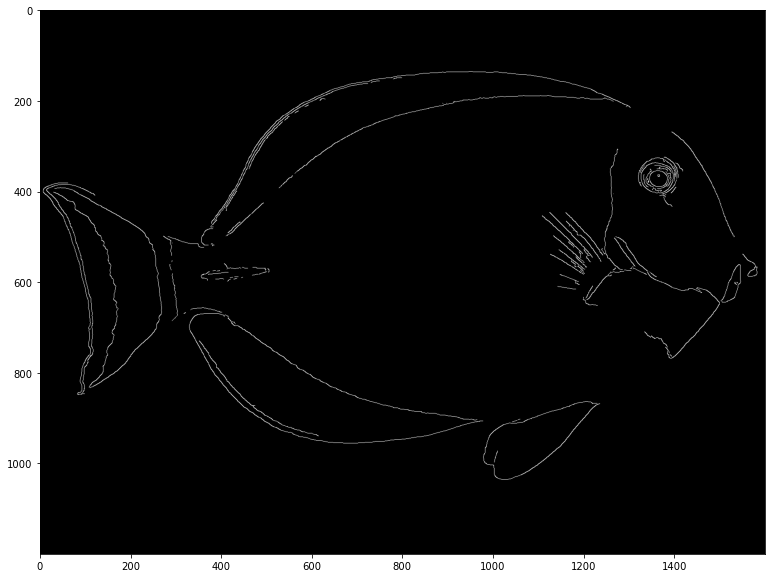

In [29]:
res, weak, strong =threshold(WINMS)
Final_Image2 =hysteresis(res,weak,strong)
plt.rcParams['figure.figsize'] = [16, 10]
plt.imshow(Final_Image2, cmap = plt.get_cmap('gray'))
plt.show()